In [2]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

s = json.load( open(os.getenv('PUIDATA')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
#download, move data to $PUIDATA, and read data in 
!curl -O https://data.cityofnewyork.us/resource/b6vf-mvej.csv
cmd = "mv b6vf-mvej.csv " + os.getenv("PUIDATA")
#the line below is to check that my string is formatted right. I should remove it to make the notebook delivery ready
print (cmd)
os.system(cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  122k    0  122k    0     0   122k      0 --:--:-- --:--:-- --:--:--  735k
mv b6vf-mvej.csv /home/cusp/as11566/PUIdata


0

In [7]:
gas_consum = pd.read_csv(os.getenv("PUIDATA")+'/b6vf-mvej.csv')
gas_consum.head(10)

,:@computed_region_92fq_4b7q,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_sbqj_enih,:@computed_region_yeji_bk3q,_consumption_gj_,_consumption_therms_,building_type_service_class,utility_data_source,zip_code,zip_code_address,zip_code_city,zip_code_state,zip_code_zip
0,NaN,NaN,NaN,NaN,NaN,50.0,470.0,Commercial,National Grid,NaN,NaN,NaN,NaN,10300
1,NaN,NaN,NaN,NaN,NaN,68.0,647.0,Commercial,National Grid,NaN,NaN,NaN,NaN,10335
2,NaN,NaN,NaN,NaN,NaN,3562.0,33762.0,Large residential,National Grid,NaN,NaN,NaN,NaN,10360
3,NaN,NaN,NaN,NaN,NaN,3389.0,32125.0,Commercial,National Grid,NaN,NaN,NaN,NaN,11200
4,NaN,NaN,NaN,NaN,NaN,380.0,3605.0,Institutional,National Grid,NaN,NaN,NaN,NaN,11200
5,NaN,NaN,NaN,NaN,NaN,418.0,3960.0,Small residential,National Grid,NaN,NaN,NaN,NaN,11200
6,NaN,NaN,NaN,NaN,NaN,200.0,1896.0,Small residential,National Grid,NaN,NaN,NaN,NaN,11254
7,NaN,NaN,NaN,NaN,NaN,882.0,8364.0,Commercial,National Grid,NaN,NaN,NaN,NaN,11274
8,NaN,NaN,NaN,NaN,NaN,272.0,2579.0,Commercial,National Grid,NaN,NaN,NaN,NaN,11279
9,NaN,NaN,NaN,NaN,NaN,32.0,301.0,Large residential,National Grid,NaN,NaN,NaN,NaN,11279


In [9]:
gas_consum = gas_consum[['zip_code_zip','_consumption_therms_']]
gas_consum.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,zip_code_zip,_consumption_therms_
count,1000.000000,9.910000e+02
mean,10856.542000,2.726147e+06
std,571.334549,4.298736e+06
min,10001.000000,1.000000e+00
25%,10305.000000,NaN
50%,11208.500000,NaN
75%,11368.000000,NaN
max,11697.000000,4.274765e+07


In [11]:
gas_consum = gas_consum.rename(columns={'zip_code_zip': 'Zip Code', '_consumption_therms_': 'Consumption'})

In [12]:
gas_consum[['Zip Code']] = gas_consum[['Zip Code']].astype(int)

In [15]:
gas_consum = gas_consum.dropna(subset=['Consumption'])
#print 'Examples after dropping NaNs:', len(gas_consum)

In [25]:
gas_consum_grb = gas_consum.groupby('Zip Code')[['Consumption']].mean().reset_index()

In [26]:
gas_consum_grb['Quartile'] = pd.qcut(gas_consum_grb['Consumption'], 5, labels=False)

gas_consum_grb.head()

,Zip Code,Consumption,Quartile
0,10001,3394380.8,3
1,10002,4302327.2,4
2,10003,3582845.6,3
3,10004,778345.0,1
4,10005,457506.0,1


In [27]:
gas_consum_grb.groupby('Quartile')[['Zip Code']].count()

,Zip Code
Quartile,
0,46
1,46
2,46
3,46
4,46


In [31]:
#import shapefile
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

zipsf = shp.Reader('NY.shp')
zipsf_records=zipsf.records()
zipsf_shape=zipsf.shapeRecords()

#for plotting our result
def plot_on_map(result):
    
    x = {}
    for i in range(len(result)):
        key=result.loc[i,'Zip Code']
        x[key]=result.loc[i,'Quartile']

    #x is a dictionary (zip codes vs values)
    cmap = plt.cm.spectral(np.linspace(0,1,max(x.values())+1))

    fig = plt.figure(figsize = (12,15)) 
    ax = fig.gca() 
    for s in range(0,len(zipsf_records)):
        z=int(zipsf_records[s][0])
        if z in x.keys(): 
            #from here
            k = x[z] 
            c=cmap[k][0:3]    
            shape=zipsf_shape[s]
            x_ = [i[0] for i in shape.shape.points[:]]
            y_ = [i[1] for i in shape.shape.points[:]]
            poly=Polygon(zip(x_,y_))
            #plt.fill(x,y,color=my_cmap[s])
            ax.add_patch(PolygonPatch(poly, fc=c, ec='k', alpha=0.5, zorder=2 ))

    ax.axis('scaled')
    plt.title("Quartile result on map")

    import matplotlib.patches as mpatches
    clum_num=len(result.iloc[:,-1].unique())

    handles=[]
    for t in range(clum_num):
        locals()["patch_{}".format(t)] = mpatches.Patch(color=cmap[t][0:3] , label='Quartile'+str(t+1))
        handles.append(locals()["patch_{}".format(t)])

    plt.legend(handles=handles,loc='upper left')
    plt.show()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


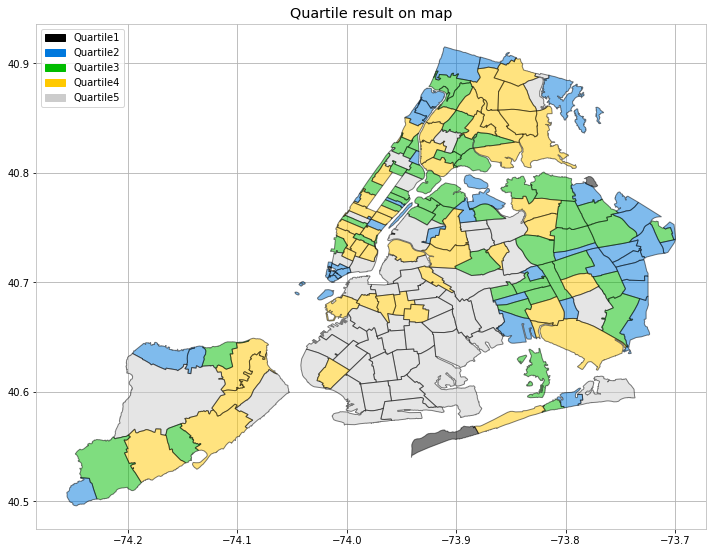

In [32]:
plot_on_map(gas_consum_grb)

### Figure 1: Figure shows the spatial distribution of Natural gas consumption color coded by Quartile(based on the overall consumption values in NYC). Brooklyn has the highest consumption in NYC which is reasonable as it is predominantly a residential area